# Causal Inference in Decision Intelligence – Part 1: A Motivating Example

Link to the article:  [A motivating Example](https://www.python.org)

## Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Set up the style of graphs
plt.style.use('fivethirtyeight')

# Display numbers with 2 decimal points
pd.options.display.float_format='{:,.2f}'.format

## Generate the data

In [2]:
# Set the sample size
n = 1000

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate dates 
start_date = '2024-05-02'
end_date = '2024-05-04'
Dates = pd.date_range(start=start_date, end=end_date)

# Create the product of Ids and dates
data_did = pd.DataFrame(product(Dates, Id))
data_did = data_did.rename(columns={0: 'Date', 1: "Id"})

# Create promo groups 
data_did['Promo'] = np.where(data_did.Id<501, 1, 0)

# Create the event
data_did['Event'] = np.where(data_did.Date=='2024-05-04', 1, 0)

# Generate Sales with the group difference equal $10, the event effect equal $5, and the promo effect equal $10
data_did['Sales'] = np.where(data_did.Id<501, 20, 10)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-04') & (data_did.Id>500)), 15, data_did.Sales)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-04') & (data_did.Id<501)), 35, data_did.Sales)

# Add the random error
np.random.seed(4)
data_did['Sales'] = data_did['Sales'] + np.random.randn(3000)

## Solution 1: Basic Statistics

In [3]:
# Use a pivot table s to calculate the effect of the promo 
round(pd.pivot_table(data_did, values='Sales', index='Promo', columns='Event', aggfunc='mean'), 1)

Event,0,1
Promo,,
0,10.00,15.00
1,20.00,35.00


The effect of the promotional campaign can be calculated as:

ATT = (35 - 20) - (15 - 10) = 10 or

ATT = (35 - 15) - (20 - 10) = 10

In [4]:
# Use statistics to calculate  the effect of the promo 
d11 = data_did[(data_did.Promo==1) & (data_did.Event==1)].Sales.mean()
d00 = data_did[(data_did.Promo==0) & (data_did.Event==0)].Sales.mean()
d01 = data_did[(data_did.Promo==0) & (data_did.Event==1)].Sales.mean()
d10 = data_did[(data_did.Promo==1) & (data_did.Event==0)].Sales.mean()
Uplift = (d11 - d10) - (d01 - d00)
print(f'Average promotional uplift: {round(Uplift, 1)}')

Average promotional uplift: 10.0


In [5]:
# Use statistics to calculate the event uplift
Event = (d01 - d00)
print(f'Average event uplift: {round(Event, 1)}')

Average event uplift: 5.0


## Solution 2: Regression with dummy variables 

In [6]:
# Estimate the effect of the promo comparing the test and the control groups using a naive approach
df1 = data_did[data_did.Date=='2024-05-04']

model_naive = smf.ols('Sales ~ Promo', df1).fit()
model_naive.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.9654,0.044,343.878,0.000,14.880,15.051
Promo,20.0369,0.062,325.560,0.000,19.916,20.158


The estimated effect of the promotional campaign is 20.04 compared to the true one equal 10. 

In [7]:
# Apply difference in differences technique to estimate the effect of the promo
model_did = smf.ols('Sales ~ Promo*Event', data_did).fit()
model_did.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0145,0.031,325.975,0.000,9.954,10.075
Promo,10.0244,0.043,230.728,0.000,9.939,10.110
Event,4.9510,0.053,93.043,0.000,4.847,5.055
Promo:Event,10.0125,0.075,133.053,0.000,9.865,10.160


The estimated effect of the promotional campaign is 10.01 compared to the true one equal 10. 

When we work with actual data, I recommend fitting the model with covariance type "cluster" grouping the observations by customer (Id): 

fit(cov_type="cluster", cov_kwds={'groups': data_did['Id']})

## Visualize the results

In [8]:
# Extract the coefficients
coef_didco = dict(model_did.params)
coef_didco = pd.DataFrame([coef_didco]).T
coef_didco = coef_didco.rename(columns={0: "Coeff"})
coef_didco.reset_index(inplace=True)
coef_didco

,index,Coeff
0,Intercept,10.01
1,Promo,10.02
2,Event,4.95
3,Promo:Event,10.01


In [9]:
# Generate the dates
start_date = '2024-05-02'
end_date = '2024-05-04'
Dates = pd.date_range(start=start_date, end=end_date)
Didco = pd.DataFrame(Dates)
Didco = Didco.rename(columns={0: "Date"})

In [10]:
# Create the dataset with the effects

# The average sales of the control group without the event
Didco['Control'] = coef_didco.iloc[0,1]

# The average sales of the control group before and during the event
Didco['Event'] = np.where((Didco.Date=='2024-05-04') , Didco['Control'] + coef_didco.iloc[2,1], Didco.Control)

# The average sales of the test group with the event and without the promotional campaign
Didco['Parallel'] = Didco['Event'] + coef_didco.iloc[1,1]

# The average sales of the test group with the event and the promotional campaign
Didco['Test'] = np.where((Didco.Date=='2024-05-04') , Didco['Parallel'] + coef_didco.iloc[3,1], Didco.Parallel)

Didco['Date'] = pd.to_datetime(Didco['Date'])
Didco

,Date,Control,Event,Parallel,Test
0,2024-05-02,10.01,10.01,20.04,20.04
1,2024-05-03,10.01,10.01,20.04,20.04
2,2024-05-04,10.01,14.97,24.99,35.00


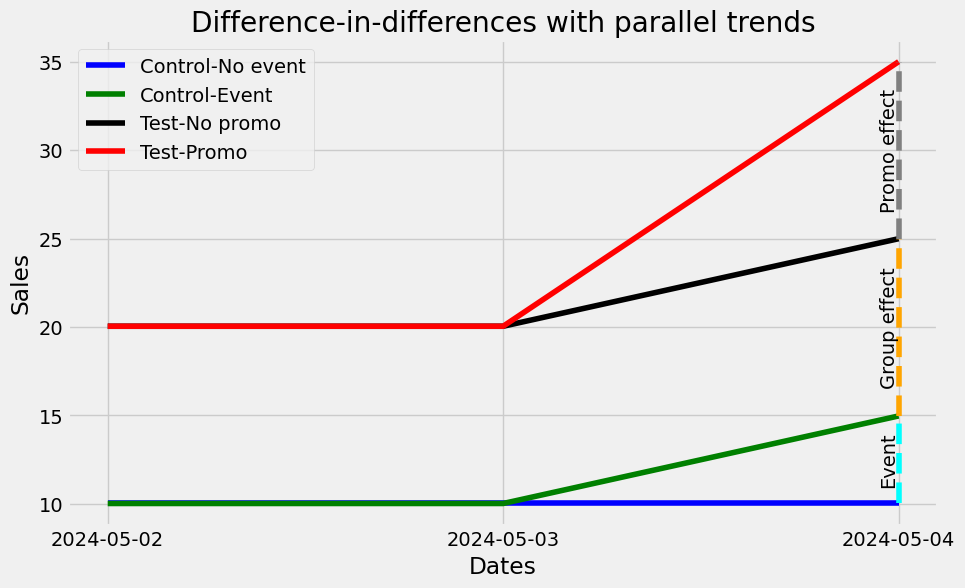

In [11]:
# Create line plots
Didco['Date'] = Didco['Date'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(Didco['Date'], Didco.Control, color='blue', label='Control-No event') 
plt.plot(Didco['Date'], Didco.Event, color='green', label='Control-Event') 
plt.plot(Didco['Date'], Didco.Parallel, color='black', label='Test-No promo') 
plt.plot(Didco['Date'], Didco.Test, color='red', label='Test-Promo') 

plt.plot([Didco['Date'][2], Didco['Date'][2]], [Didco['Parallel'][2], Didco['Test'][2]], linestyle='--', color='gray')
plt.text(Didco['Date'][2], 30, 'Promo effect', rotation=90, verticalalignment='center', horizontalalignment='right')
plt.plot([Didco['Date'][2], Didco['Date'][2]], [Didco['Control'][2], Didco['Event'][2]], linestyle='--', color='cyan') 
plt.text(Didco['Date'][2], 12.5, 'Event', rotation=90, verticalalignment='center', horizontalalignment='right')
plt.plot([Didco['Date'][2], Didco['Date'][2]], [Didco['Event'][2], Didco['Parallel'][2]], linestyle='--', color='orange') 
plt.text(Didco['Date'][2], 20, 'Group effect', rotation=90, verticalalignment='center', horizontalalignment='right')

# Add titles and labels 
plt.title('Difference-in-differences with parallel trends') 
plt.xlabel('Dates') 
plt.ylabel('Sales') 

# Add a legend 
plt.legend() 

# Show the plot 
plt.show();